# Understanding Bootstrapping With Strava Run Data

## Why bootstrapping in the first place?

More often than not, data observed or collected have a couple of problems, one of the most common being: we don't know the underlying distribution of our data. And even if we can infer the underlying distribution, other (parametric) methods require assumptions we may not want to make.

One of my recent hobbies has been running, which my friend has gotten me into. I'm curious about whether or not I'm catching up to them in terms of performance because, although we've both logged some runs this year, our paces can vary greatly. As such, it's not obvious on whether or not there is a meaningful difference in our speeds.

This raised a practical question: how can I quantify uncertainty in our average speeds and the difference between them, without assuming anything about how our run data is distributed?

## Why can't we assume distributions?

One follow-up question may be: why wouldn't we want to assume the distribution of data? Especially in the case of my runs which (as you will see later) seem to be normally distributed, why can't we just they are and move on?

1. We don't **truly** know the underlying distribution. Although we can make educated guesses, assuming one distribution but being completely incorrect can be costly. This particular case is low-stakes (as no one *really* cares about the speed of my runs and my friend's runs); however, suppose we are statisticians with patient recovery times in a clinical trial. Our claims now become much higher-stakes: our findings are directly responsible for  people's lives. If we assume recovery times are normally distributed but, in reality, are skewed right, confidence intervals and p-values become unreliable, which give false conclusions and can cause significant harm.

2. Real-world data often violates assumptions. If you assume a distribution, you're also inheriting all the assumptions that come with it (such as homoscedasticity and independence in a normal distribution). And the truth is, real-world data is messy. Making strong distributional assumptions is often naive. Bootstrapping, on the other hand, completely bypasses these assumptions. Because it’s a *non-parametric* method, it doesn’t rely on any specific distribution or require us to make those assumptions. Furthermore, because it's a non-parametric test, bootstrapping doesn't come with the limitations of a parametric one (for instance, only using the means like a t-test would).


3. Distribution assumptions are unreliable and hard to generalize with small sample sizes. Bootstrapping solves this problem with its method (which we will describe in a bit). This is perhaps the biggest advantage: a common problem in early-stage trials, niche experiments, or personal projects is they often lack funding or time to gather large datasets. And because parametric methods often need larger datasets to safely rely on their assumptions, generating meaningful results from a small sample size can be difficult. Resampling methods, like bootstrapping, help mitigate this issue and allows for meaningful conclusions without making sweeping overgeneralizations.

Let's take a look at the data collected.

*Note the data was collected through the Strava API. Please see the .ipynb titled "Data Collection." Please note this data was cleaned.*

In [7]:
# read in appropriate libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

# read in data
df = pd.read_csv("Runs.csv")

# ensure dates are in datetime format
df['start_date_local'] = pd.to_datetime(df['start_date_local'])

# aggregate specific runs between my run and my friend's run
my_runs = df[(df['friendNum'] == 0) & (df['type'] == 'Run')]
f2_runs = df[(df['friendNum'] == 2) & (df['type'] == 'Run')]

In [8]:
# define a function that creates a scatter plot of the any run data

def plot_time_scatter(x1, y1, xlabel, ylabel, title, compare = False, x2 = None, y2 = None, label1 = None, label2 = None):

    plt.figure(figsize = (12, 6))
    
    if not compare:
        plt.scatter(x1, y1, alpha = 0.6)

    else:
        plt.scatter(x1, y1, alpha = 0.6, label = label1)
        plt.scatter(x2, y2, alpha = 0.6, label = label2, color='orangered')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

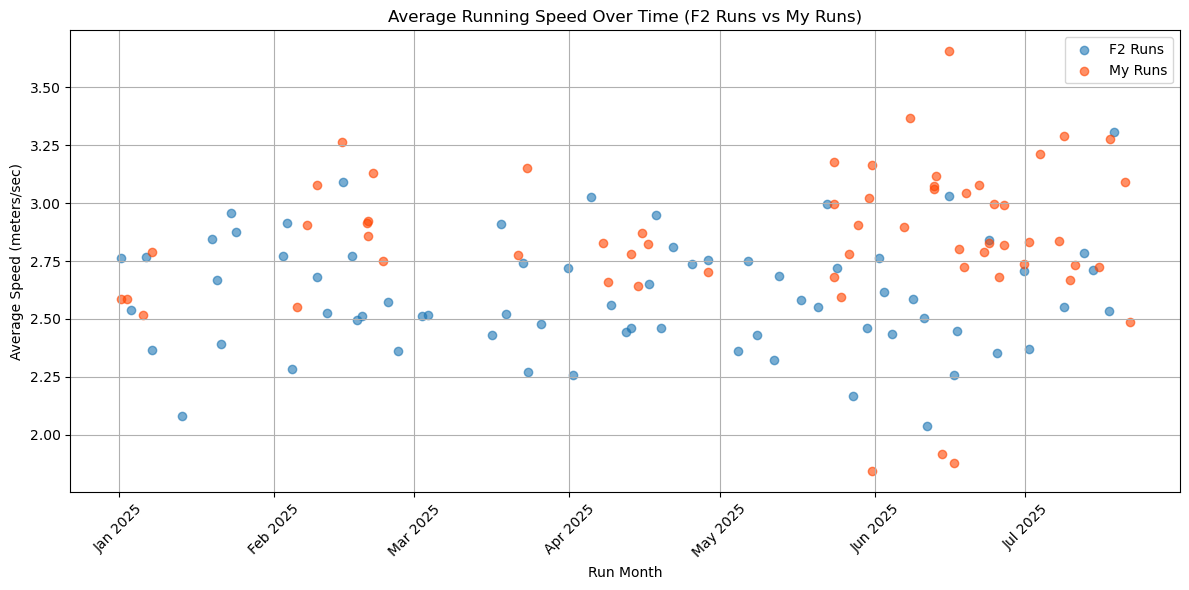

In [9]:
plot_time_scatter(x1 = f2_runs['start_date_local'],
                  y1 = f2_runs['average_speed'],
                  xlabel = 'Run Month',
                  ylabel = 'Average Speed (meters/sec)',
                  title = 'Average Running Speed Over Time (F2 Runs vs My Runs)',
                  compare = True,
                  x2 = my_runs['start_date_local'],
                  y2 = my_runs['average_speed'],
                  label1 = 'F2 Runs',
                  label2 = 'My Runs')

This scatter plot is a great example as to why bootstrapping is useful.

Each point in the scatter plot above represents a run, done either by my friend (blue) or me (orange red). The x-axis shows the time frame of the runs (beginning of 2025 till July 2025) whereas the y-axis shows the average speed in each run that was done. Notice how there is a lot of overlap before June: on some days, I'm faster; on others, he is. Once July hits, however, my runs seem to trend faster (though not by much).

Note the large amount of noise. Speeds jump around and are all-around inconsistent, making it hard to confidently say who is faster based on just this plot alone. It is obvious this graph does not tell the full story.

If one graph doesn't tell the full story, why not create more?

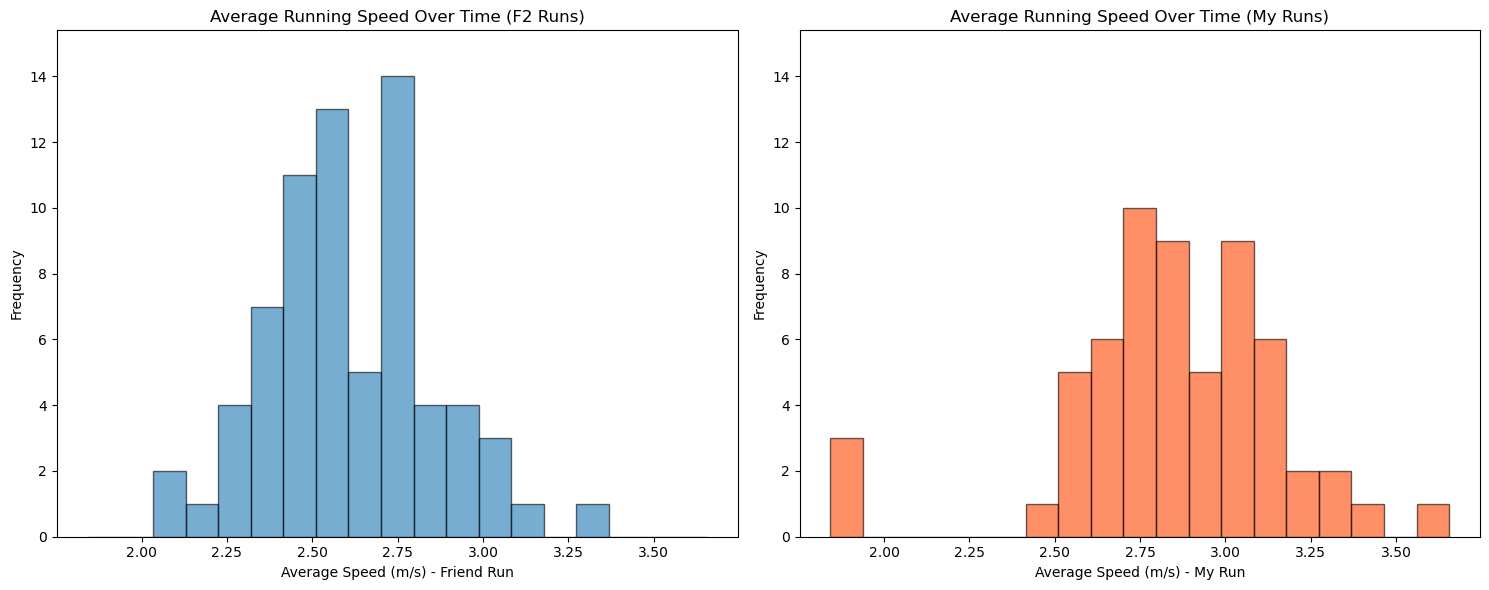

In [11]:
# create scatter plot of both average speeds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

all_speeds = list(f2_runs['average_speed']) + list(my_runs['average_speed'])
bins = np.linspace(min(all_speeds), max(all_speeds), 20)

n1, _, _ = ax1.hist(f2_runs['average_speed'], bins = bins, alpha = 0.6, edgecolor = 'black')
n2, _, _ = ax2.hist(my_runs['average_speed'], bins = bins, color = 'orangered', alpha = 0.6, edgecolor = 'black')

y_max = max(n1.max(), n2.max()) * 1.1  # Add 10% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

ax1.set_xlabel('Average Speed (m/s) - Friend Run')
ax1.set_ylabel('Frequency')
ax1.set_title('Average Running Speed Over Time (F2 Runs)')

ax2.set_xlabel('Average Speed (m/s) - My Run')
ax2.set_ylabel('Frequency')
ax2.set_title('Average Running Speed Over Time (My Runs)')

plt.tight_layout()
plt.show()

To get a better sense of how our running speeds are distributed, I plotted two other histograms (both on the same frequency scale). There are two key points:

1. Both of our runs seem to be generally normally distributed and unimodal. Our speeds also seem to center around 2.7 meters per second. Notice how the shape of mine is a bit wider, indicating a larger spread and more variance of my runs.

2. I run less than my friend. Since both histograms are on the same scale (y-axis), it's really easy to tell that my I have less points. In fact, if we actually calculate the number of runs we both have, we see that my friend has more than me.

In [13]:
print(f"Friends Runs: {f2_runs.shape[0]}" )
print(f"My Runs: {my_runs.shape[0]}")

Friends Runs: 70
My Runs: 60


Looking at the data, one great and intuitive idea could be to use a t-test and compare the means. However, by exploring each of the points at the beginning of this section, we can see why performing a t-test may be unfavorable.

1. Although the data looks generally normal, we don't truly know that it is. Note the dip in frequencies values right before (general) center of our histograms; notice also the slight skew to the left in my friend's data and slight skew to the right in my runs. These differences won't ruin a t-test, but they are definitely something to take note of.

2. A t-test has many assumptions, one of which is that the distributions are independent and identically distributed (iid). My friend and I are regularly talk about our runs and are competitive people, which makes me confident that our runs (consciously or unconsciously) are affected by each other. Furthermore, the runs distributions between our runs don't look exactly the same; as such, the iid assumption is violated.

3. Our sample sizes aren't exactly small for a t-test (statisticians usually cite minimum 30 participants), so this argument is a bit weak. Nonetheless, a t-test is best used when our sample size is larger; although 60 and 70 is serviceable, it would be ideal to have a larger sample size.

## What is bootstrapping?

With all that being said, what is bootstrapping?

Bootstrapping steps are:

1. Randomly sample the dataset with replacement.

2. Compute the statistic of interest (in this case, we will use the mean).

3. Repeat the process many times to get an array containing your statistic of interest.

4. Analyze the distribution of the bootstrapped statistic of interest.

This process estimates the variability of the chosen statistic; instead of relying on assumptions, bootstrapping simulates the process of drawing samples from the population by sampling from our own sample.

This does multiple things:

1. Allows us to quantify uncertainty in our estimate with confidence intervals

2. Visualize the range of our statistic if we were to sample again.

3. Perform hypothesis testing with flexibtility.

The `bootstrap_mean()` function performs steps 1-3.

In [17]:
import numpy as np

# define function to perform bootstrapping
def bootstrap_mean(data, n_boot = 1000):
    means = [] # initialize empty array to store means
    for _ in range(n_boot): # repeat process many times
        sample = np.random.choice(data, size=len(data), replace=True) # randomly sample dataset with replacement
        means.append(np.mean(sample)) # compute statistic of interest and store mean in array
        
    return np.array(means)
    
    # alternatively, shorthand, using list comprehension:
    # return np.array([(np.mean(np.random.choice(data, size=len(data), replace=True))) for _ in range(n_boot)])

In [18]:
# initialize seed for reproducibility
np.random.RandomState(42)

f2_means = bootstrap_mean(f2_runs['average_speed']) # perform bootstrapping on friend's runs
my_means = bootstrap_mean(my_runs['average_speed']) # perform bootstrapping on my runs
f2_ci = np.percentile(f2_means, [2.5, 97.5]) # find 95th percentile for friend's runs
me_ci = np.percentile(my_means, [2.5, 97.5]) # find 95th percentile for my runs

In [19]:
# create histogram for visual representation of bootstrapping individual runs

def plot_histogram(y1, xlabel, ylabel, title, ci1, compare = False, y2 = None, label1 = None, label2 = None, ci2 = None, bins = 20):
    
    plt.figure(figsize=(10, 6))
    
    plt.hist(y1, bins=bins, alpha=0.6, label=label1, edgecolor='black')
    
    plt.axvline(ci1[0], alpha = 0.4, linestyle='--', linewidth=2, label=f'{label1 or "Data 1"} 95% CI')
    plt.axvline(ci1[1], alpha = 0.4, linestyle='--', linewidth=2)
    
    y_max = plt.ylim()[1]
    plt.axvspan(ci1[0], ci1[1], alpha=0.1)
        
    if compare:
        plt.hist(y2, bins=bins, alpha=0.6, label=label2, edgecolor='black', color='orangered')
        plt.axvline(ci2[0], color='orangered', alpha = 0.4, linestyle='--', linewidth=2, label=f'{label2 or "Data 2"} 95% CI')
        plt.axvline(ci2[1], color='orangered', alpha = 0.4, linestyle='--', linewidth=2)
        plt.axvspan(ci2[0], ci2[1], alpha=0.1, color = 'orangered')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

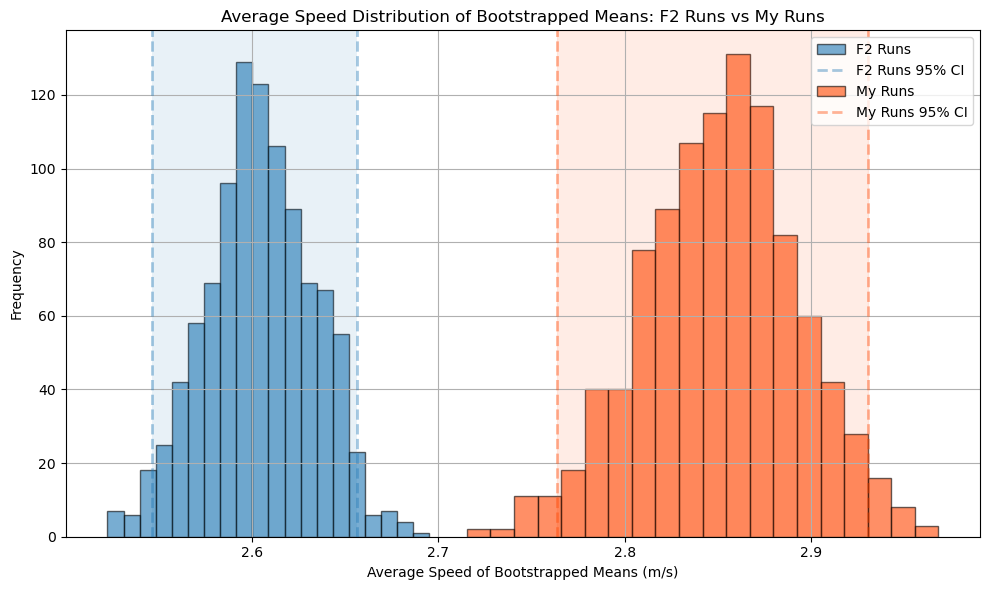

In [20]:
plot_histogram(
    y1 = f2_means,
    y2 = my_means,
    ci1 = f2_ci,
    ci2 = me_ci,
    xlabel='Average Speed of Bootstrapped Means (m/s)',
    ylabel='Frequency',
    title='Average Speed Distribution of Bootstrapped Means: F2 Runs vs My Runs',
    compare=True,
    label1='F2 Runs',
    label2='My Runs'
)

Above is the result of our bootstrap: simulated means graphed on a histogram showing two very distinct distributions: one for my runs and one for my friend’s. Notably, the confidence intervals do not overlap at all, which strongly suggests that the average speeds between the two groups are meaningfully different. This separation implies that, across many possible resamples of the data, the average speed from each group consistently falls into a different range. The lack of overlap on this histogram provides strong evidence that the difference we observe is not just due to random variation, but reflects a real underlying difference in the average speed of our runs.

## What else can we do?

I would be a terrible statistician if I simply let one result lead my conclusion, so I do want to perform one more test: a permutation test.

Although this method isn't the main topic of this blog, it is another powerful resampling method that will really hit the point home for the results of the bootstrap. The quick summary of a permutation test is as so:

1. Compute the observed statistic (in this case, difference in means between my friend's runs and my runs).

2. Combine the groups together (so my friend's runs and my runs go into one pool).

3. Randomly shuffle the data.

4. Arbitrarily assign the data back into two groups with the same original sizes (so one of my runs may be labeled as my friend's and vice-versa).

5. Recalculate the statistic under the two groups with the shuffled data.

6. Repeat steps 3-5 to build a distribution of the statistic.

7. Compare the observed statistic to the permutation distribution to get a p-value under the null hypothesis (there is no difference between both groups).

The permutation test is shown below:

In [24]:
diff_orig = my_runs['average_speed'].mean() - f2_runs['average_speed'].mean() # compute the observed statistic
n_f2, n_my = len(f2_runs['average_speed']), len(my_runs['average_speed']) # calculate lengths to enable arbitrary reassignment back into original groups

combined = np.concatenate([f2_runs['average_speed'], my_runs['average_speed']]) # combine the observed statistic
null_diffs = [] # initialize array for differences
for _ in range(1000): # repeat process many times
    np.random.shuffle(combined) # randomly shuffle data
    boot_f2, boot_my = combined[:n_f2], combined[n_f2:] # arbitrarily assign the data back into two groups with the same original sizes
    null_diffs.append(np.mean(boot_my) - np.mean(boot_f2)) # recalculate the statistic under the two grouped with the shuffled data


p_val_null = np.mean(np.abs(null_diffs) >= np.abs(diff_orig))
f'{p_val_null:.4f}'

'0.0000'

The result from this permutation test supports the claim that there is a meaningful difference between our runs. Suppose our alpha value is 0.05; since the p-value is less than 0.05, we reject the null hypothesis (there is is no observed difference in means between my friend's runs and my runs) and we have reason to believe there is a meaningful difference between our runs.

If you would like an amazing representation of a permutation test, please refer to this page by [Jared Wilber](https://www.jwilber.me/permutationtest/), who has created a fun and amazing visual of a permutation test involving sheep!

## Dashboard (app.py)

I have created a dashboard that combines everything we've done in this short blog all into one. Click generate and you'll see different simulations of bootstrapping; notice how almost every (if not all) times you click generate, the confidence intervals never overlap and the permutation test consistently show statistically significant results. 